"Lethality Fitting"
-----------------------
This is a script by Elden to attempt to classify lethality of proteins (as defined by the <it>essential protein</it> list) by their degree, SC, etc.

In [1]:
"""Imports and arguments"""

import csv

import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import network_utilities as nu
import random
import networkx.algorithms.community as nx_comm
import tensorflow as tf

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

extra_outputs = False;

In [2]:
"""Loading data"""

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
if (extra_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

    plt.hist(these_weights, bins=40);
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
print(G)

Graph with 5932 nodes and 119977 edges


In [73]:
# Let's generate the binary array to color nodes:

ess_selector = nu.value_lambda_result(
    list(G.nodes), # values
    [lambda p: p in ess_list], # tests
    [1], # results
    default = 0); 

ess_colors = ['red' if k == 1 else 'blue' for k in ess_selector]

# and some random names:
rand_name_period = 100

name_list_full = list(G.nodes) 
name_list_cutdown = [name_list_full[n] if n % rand_name_period == 0 else None for n in range(len(name_list_full))]
just_one_name = [name if name == "YPT232W" else None for name in name_list_full]

Let's look at the distribution of nodes w.r.t. a few properties, colored by essentiality, to see if we can see any trends.

Each cell runs an individual measure for processing efficiency, then the chosen two are run by the last cell. The cells are roughly ordered in order of runtime.

In [4]:
degrees_labeled = list(G.degree);
degrees = [d[1] for d in degrees_labeled] # stripping away the labels

In [5]:
eigen_centrality = list(nx.eigenvector_centrality(G).values())

In [6]:
subgraph_centrality = list(nx.subgraph_centrality(G).values())

In [10]:
# Veeeery long. Uncomment at your peril. Of course we would prefer to avoid computationally expensive measure! 
#est_samples = 2; 

# we can limit the number of nodes it checks to trade accuracy for speed
# Buuuut even with this parameter this is too long

#betweenness_centrality = list(nx.betweenness_centrality(G).values(),est_samples)

In [12]:
# Veeeery long. Uncomment at your peril. Of course we would prefer to avoid computationally expensive measure! 
# closeness_centrality = list(nx.closeness_centrality(G).values())

In [ ]:
# Cross-clique connectivity is NP-complete with exp running time, so we cannot practically use it
# 

Now we plot the desired pairs:

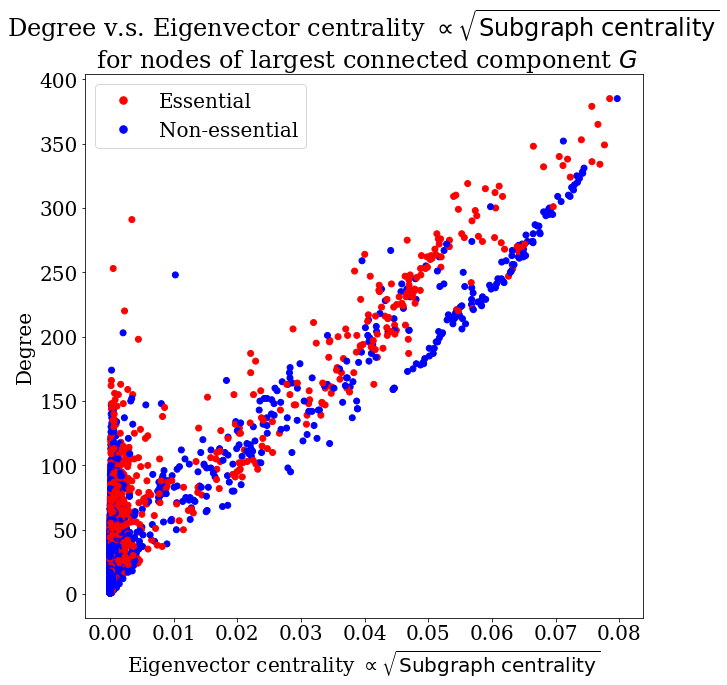

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(eigen_centrality, degrees, c = ess_colors)
plt.title("Degree v.s. Eigenvector centrality $\propto\sqrt{\mathrm{Subgraph\;centrality}}$\n for nodes of largest connected component $G$")
plt.xlabel("Eigenvector centrality $\propto \sqrt{\mathrm{Subgraph\;centrality}}$");
plt.ylabel("Degree")

# Compose a custom legend to label the colors:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='.', color='red', label='Essential',
                          markerfacecolor='red', markersize=15, linewidth=0),
                   Line2D([0], [0], marker='.', color='blue', label='Non-essential',
                          markerfacecolor='blue', markersize=15, linewidth=0)]

plt.legend(handles=legend_elements, loc='best')

# To zoom in:
naming_nodes = False
if (naming_nodes):
    Zooming_in = False
    if (Zooming_in):
        x_min = 0
        x_max = 0.001
        y_min = 0 
        y_max = 50
        plt.xlim([x_min,x_max])
        plt.ylim([y_min,y_max])
        for i in range(len(eigen_centrality)):
            if (name_list_cutdown[i] is not None):
                if (eigen_centrality[i] > x_min and eigen_centrality[i] < x_max
                   and degrees[i] > y_min and degrees[i] < y_max):
                    plt.text(eigen_centrality[i], degrees[i],name_list_cutdown[i], fontsize=10)
    else:
        for i in range(len(eigen_centrality)):
            if (name_list_cutdown[i] is not None):
                plt.text(eigen_centrality[i], degrees[i],name_list_cutdown[i], fontsize=10)

just_one = True
if (just_one):
    for i in range(len(eigen_centrality)):
        if (just_one_name[i] is not None):
            plt.text(eigen_centrality[i], degrees[i],just_one_name[i], fontsize=10)
        

plt.show()

### Observations

We see that subgraph and eigenvector centrality almost exactly correlate:

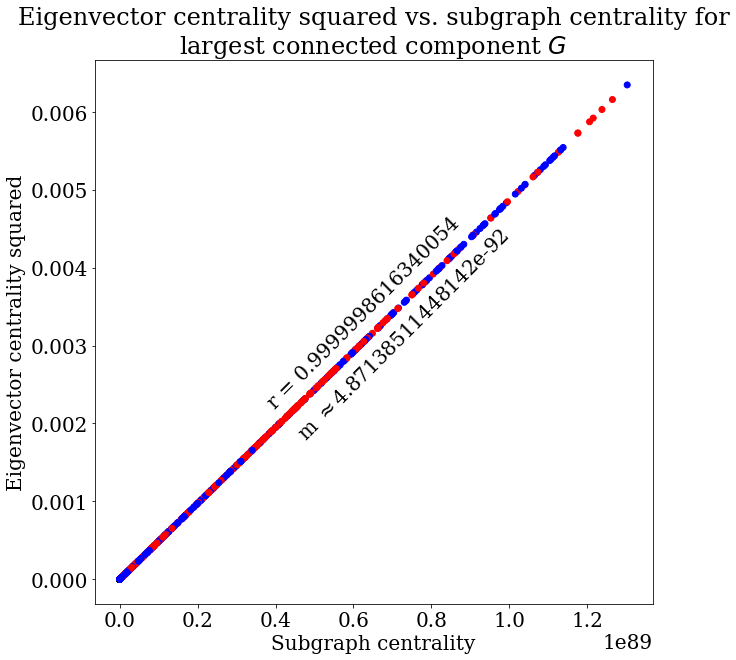

In [49]:
eigen_centrality_sq  = [c**2 for c in eigen_centrality]

plt.figure(figsize=(10,10))
plt.scatter(subgraph_centrality,eigen_centrality_sq, c = ess_colors)
plt.title("Eigenvector centrality squared vs. subgraph centrality for\nlargest connected component $G$")
plt.xlabel("Subgraph centrality");
plt.ylabel("Eigenvector centrality squared")

corr_coeff = np.corrcoef(subgraph_centrality,eigen_centrality_sq)[1,0];

fit_gradient = (max(eigen_centrality_sq)-min(eigen_centrality_sq))/(max(subgraph_centrality)-min(subgraph_centrality)) # approx'! 

plt.text(3.7e88,0.0018, "r = "+ str(corr_coeff) +"\n\n" + r"m $\approx$"+str(fit_gradient),rotation=45)

plt.show()

